# Video Classification - Model Training
## Big Vision Internship Assignment

This notebook covers:
1. Model architecture setup
2. Training configuration
3. Training loop with mixed precision
4. Model checkpointing and logging
5. Training visualization

**Model**: VideoMAE / TimeSformer

In [1]:
# Import libraries
import sys
sys.path.append('..')

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
import yaml
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from utils.data_utils import create_data_loaders, load_splits
from utils.model_utils import (
    create_model, get_optimizer, get_scheduler,
    save_checkpoint, get_model_summary, EarlyStopping
)
from utils.training_utils import (
    train_one_epoch, validate,
    LabelSmoothingCrossEntropy
)
from utils.visualization_utils import plot_training_history

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Libraries imported successfully!
PyTorch version: 2.4.1+cu121
CUDA available: True


## 1. Setup and Configuration

In [2]:
# Load configuration
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

# Set seeds
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])

# Create output directories (adjust paths for notebook location)
def resolve_path(path_str):
    """Convert config paths (relative to project root) to notebook paths"""
    if path_str.startswith('./'):
        return Path('..') / path_str[2:]
    return Path(path_str)

models_dir = resolve_path(config['output']['models_dir'])
log_dir = resolve_path(config['logging']['log_dir'])
models_dir.mkdir(parents=True, exist_ok=True)
log_dir.mkdir(parents=True, exist_ok=True)

print("\n📋 Training Configuration:")
print(f"   Model: {config['model']['name']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Epochs: {config['training']['num_epochs']}")
print(f"   Learning rate: {config['training']['optimizer']['lr']}")
print(f"   Mixed precision: {config['training']['mixed_precision']}")

🖥️  Using device: cuda

📋 Training Configuration:
   Model: videomae
   Batch size: 8
   Epochs: 50
   Learning rate: 0.0001
   Mixed precision: True


## 2. Load Data

In [3]:
# Load splits
splits_dir = resolve_path(config['dataset']['splits_dir'])
splits = load_splits(str(splits_dir))

train_files = splits['train']['files']
train_labels = splits['train']['labels']
val_files = splits['val']['files']
val_labels = splits['val']['labels']
class_names = splits['class_names']
num_classes = len(class_names)

print(f"📊 Dataset loaded:")
print(f"   Train samples: {len(train_files)}")
print(f"   Val samples: {len(val_files)}")
print(f"   Number of classes: {num_classes}")

# Create data loaders
print("\n🔄 Creating data loaders...")
train_loader, val_loader, _ = create_data_loaders(
    config, train_files, train_labels,
    val_files, val_labels
)

print(f"✅ Data loaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

📊 Dataset loaded:
   Train samples: 487
   Val samples: 104
   Number of classes: 5

🔄 Creating data loaders...
✅ Data loaders created:
   Train batches: 60
   Val batches: 7


## 3. Create Model

In [4]:
# Create model
print("🏗️  Creating model...")
model = create_model(
    model_name=config['model']['name'],
    num_classes=num_classes,
    config=config['model'],
    pretrained=config['model']['pretrained']
)

model = model.to(device)

# Model summary
summary = get_model_summary(model)
print(f"\n✅ Model created:")
print(f"   Total parameters: {summary['total_parameters']:,}")
print(f"   Trainable parameters: {summary['trainable_parameters']:,}")
print(f"   Model size: {summary['model_size_mb']:.2f} MB")

🏗️  Creating model...


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model created:
   Total parameters: 86,231,045
   Trainable parameters: 86,231,045
   Model size: 328.95 MB


## 4. Setup Training Components

In [5]:
# Loss function
if config['advanced'].get('label_smoothing', 0) > 0:
    criterion = LabelSmoothingCrossEntropy(config['advanced']['label_smoothing'])
else:
    criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = get_optimizer(model, config)

# Learning rate scheduler
num_training_steps = len(train_loader) * config['training']['num_epochs']
scheduler = get_scheduler(optimizer, config, num_training_steps)

# Mixed precision scaler
scaler = GradScaler() if config['training']['mixed_precision'] else None

# Early stopping
early_stopping = None
if config['training']['early_stopping']['enabled']:
    early_stopping = EarlyStopping(
        patience=config['training']['early_stopping']['patience'],
        min_delta=config['training']['early_stopping']['min_delta'],
        mode=config['training']['checkpoint']['mode']
    )

print("✅ Training components initialized")

✅ Training components initialized


In [6]:
## 5. Training Loop

# Check GPU
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print(f"🖥️  Training Device: {device_name}")
if torch.cuda.is_available():
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")

# Initialize tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

best_val_loss = float('inf')
start_epoch = 0

# Resume from checkpoint if exists
resume_checkpoint = models_dir / "last_checkpoint.pth"
if resume_checkpoint.exists():
    print(f"🔄 Found checkpoint! Resuming training from {resume_checkpoint}")
    checkpoint = torch.load(resume_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('best_metric', float('inf'))
    if 'history' in checkpoint:
        history = checkpoint['history']
    print(f"✅ Resumed from epoch {start_epoch}, Best Val Loss: {best_val_loss:.4f}\n")

print("🚀 Starting training...\n")

# Training loop
for epoch in range(start_epoch, config['training']['num_epochs']):
    print("="*70)
    print(f"Epoch {epoch+1}/{config['training']['num_epochs']}")
    print("="*70)
    
    # Train
    train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer,
        scheduler, device, epoch+1, config, scaler
    )
    
    # Validate
    val_metrics = validate(model, val_loader, criterion, device, config)
    
    # Update history
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"   Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}%")
    print(f"   Val Loss:   {val_metrics['loss']:.4f} | Val Acc:   {val_metrics['accuracy']:.2f}%")
    print(f"   LR:         {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        checkpoint_path = models_dir / f"best_model_epoch_{epoch+1}.pth"
        save_checkpoint(
            model, optimizer, scheduler, epoch+1,
            best_val_loss, checkpoint_path, 
            config=config, history=history
        )
        print(f"   💾 Best model saved! (Val Loss: {best_val_loss:.4f})")
    
    # Save last checkpoint for resuming
    last_checkpoint_path = models_dir / "last_checkpoint.pth"
    save_checkpoint(
        model, optimizer, scheduler, epoch+1,
        best_val_loss, last_checkpoint_path,
        config=config, history=history
    )
    
    # Early stopping check
    if early_stopping is not None:
        early_stopping(val_metrics['loss'])
        if early_stopping.early_stop:
            print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
            break
    
    print()

print("\n" + "="*70)
print("✅ Training Complete!")
print("="*70)

🖥️  Training Device: Tesla T4
💾 GPU Memory: 15.66 GB

🚀 Starting training...

Epoch 1/50


Epoch 1:   0%|          | 0/60 [00:00<?, ?it/s]

Validation: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=0.9778]



📊 Epoch 1 Summary:
   Train Loss: 1.2994 | Train Acc: 0.50%
   Val Loss:   0.9778 | Val Acc:   0.73%
   LR:         9.99e-05
   💾 Best model saved! (Val Loss: 0.9778)

Epoch 2/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it, loss=0.8331]



📊 Epoch 2 Summary:
   Train Loss: 0.8689 | Train Acc: 0.79%
   Val Loss:   0.8331 | Val Acc:   0.82%
   LR:         9.96e-05
   💾 Best model saved! (Val Loss: 0.8331)

Epoch 3/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it, loss=0.9449]



📊 Epoch 3 Summary:
   Train Loss: 0.7037 | Train Acc: 0.88%
   Val Loss:   0.9449 | Val Acc:   0.77%
   LR:         9.91e-05

Epoch 4/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, loss=0.6992]



📊 Epoch 4 Summary:
   Train Loss: 0.6920 | Train Acc: 0.89%
   Val Loss:   0.6992 | Val Acc:   0.88%
   LR:         9.84e-05
   💾 Best model saved! (Val Loss: 0.6992)

Epoch 5/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it, loss=0.5897]



📊 Epoch 5 Summary:
   Train Loss: 0.6052 | Train Acc: 0.93%
   Val Loss:   0.5897 | Val Acc:   0.94%
   LR:         9.76e-05
   💾 Best model saved! (Val Loss: 0.5897)

Epoch 6/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=0.6141]



📊 Epoch 6 Summary:
   Train Loss: 0.5662 | Train Acc: 0.96%
   Val Loss:   0.6141 | Val Acc:   0.94%
   LR:         9.65e-05

Epoch 7/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=0.5647]



📊 Epoch 7 Summary:
   Train Loss: 0.5214 | Train Acc: 0.97%
   Val Loss:   0.5647 | Val Acc:   0.95%
   LR:         9.53e-05
   💾 Best model saved! (Val Loss: 0.5647)

Epoch 8/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it, loss=0.5440]



📊 Epoch 8 Summary:
   Train Loss: 0.5363 | Train Acc: 0.96%
   Val Loss:   0.5440 | Val Acc:   0.95%
   LR:         9.39e-05
   💾 Best model saved! (Val Loss: 0.5440)

Epoch 9/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=0.5774]



📊 Epoch 9 Summary:
   Train Loss: 0.5263 | Train Acc: 0.97%
   Val Loss:   0.5774 | Val Acc:   0.96%
   LR:         9.23e-05

Epoch 10/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, loss=0.6059]



📊 Epoch 10 Summary:
   Train Loss: 0.4927 | Train Acc: 0.99%
   Val Loss:   0.6059 | Val Acc:   0.93%
   LR:         9.05e-05

Epoch 11/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=0.5726]



📊 Epoch 11 Summary:
   Train Loss: 0.4954 | Train Acc: 0.99%
   Val Loss:   0.5726 | Val Acc:   0.95%
   LR:         8.86e-05

Epoch 12/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=0.5836]



📊 Epoch 12 Summary:
   Train Loss: 0.4871 | Train Acc: 0.99%
   Val Loss:   0.5836 | Val Acc:   0.95%
   LR:         8.66e-05

Epoch 13/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=0.5586]



📊 Epoch 13 Summary:
   Train Loss: 0.4871 | Train Acc: 0.99%
   Val Loss:   0.5586 | Val Acc:   0.95%
   LR:         8.44e-05

Epoch 14/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, loss=0.4684]



📊 Epoch 14 Summary:
   Train Loss: 0.4824 | Train Acc: 0.99%
   Val Loss:   0.4684 | Val Acc:   1.00%
   LR:         8.21e-05
   💾 Best model saved! (Val Loss: 0.4684)

Epoch 15/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=0.4801]



📊 Epoch 15 Summary:
   Train Loss: 0.4811 | Train Acc: 0.99%
   Val Loss:   0.4801 | Val Acc:   0.99%
   LR:         7.96e-05

Epoch 16/50


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it, loss=0.4663]



📊 Epoch 16 Summary:
   Train Loss: 0.4680 | Train Acc: 1.00%
   Val Loss:   0.4663 | Val Acc:   1.00%
   LR:         7.70e-05
   💾 Best model saved! (Val Loss: 0.4663)

⚠️ Early stopping triggered at epoch 16

✅ Training Complete!


## 6. Save Training History and Visualize

In [11]:
# Reload the visualization module to get latest changes
import importlib
import sys
if 'utils.visualization_utils' in sys.modules:
    importlib.reload(sys.modules['utils.visualization_utils'])
from utils.visualization_utils import plot_training_history

# Then run the rest of your cell...

💾 Training history saved to ../outputs/logs/training_history.json
Training history plot saved to ../outputs/visualizations/training_history.png


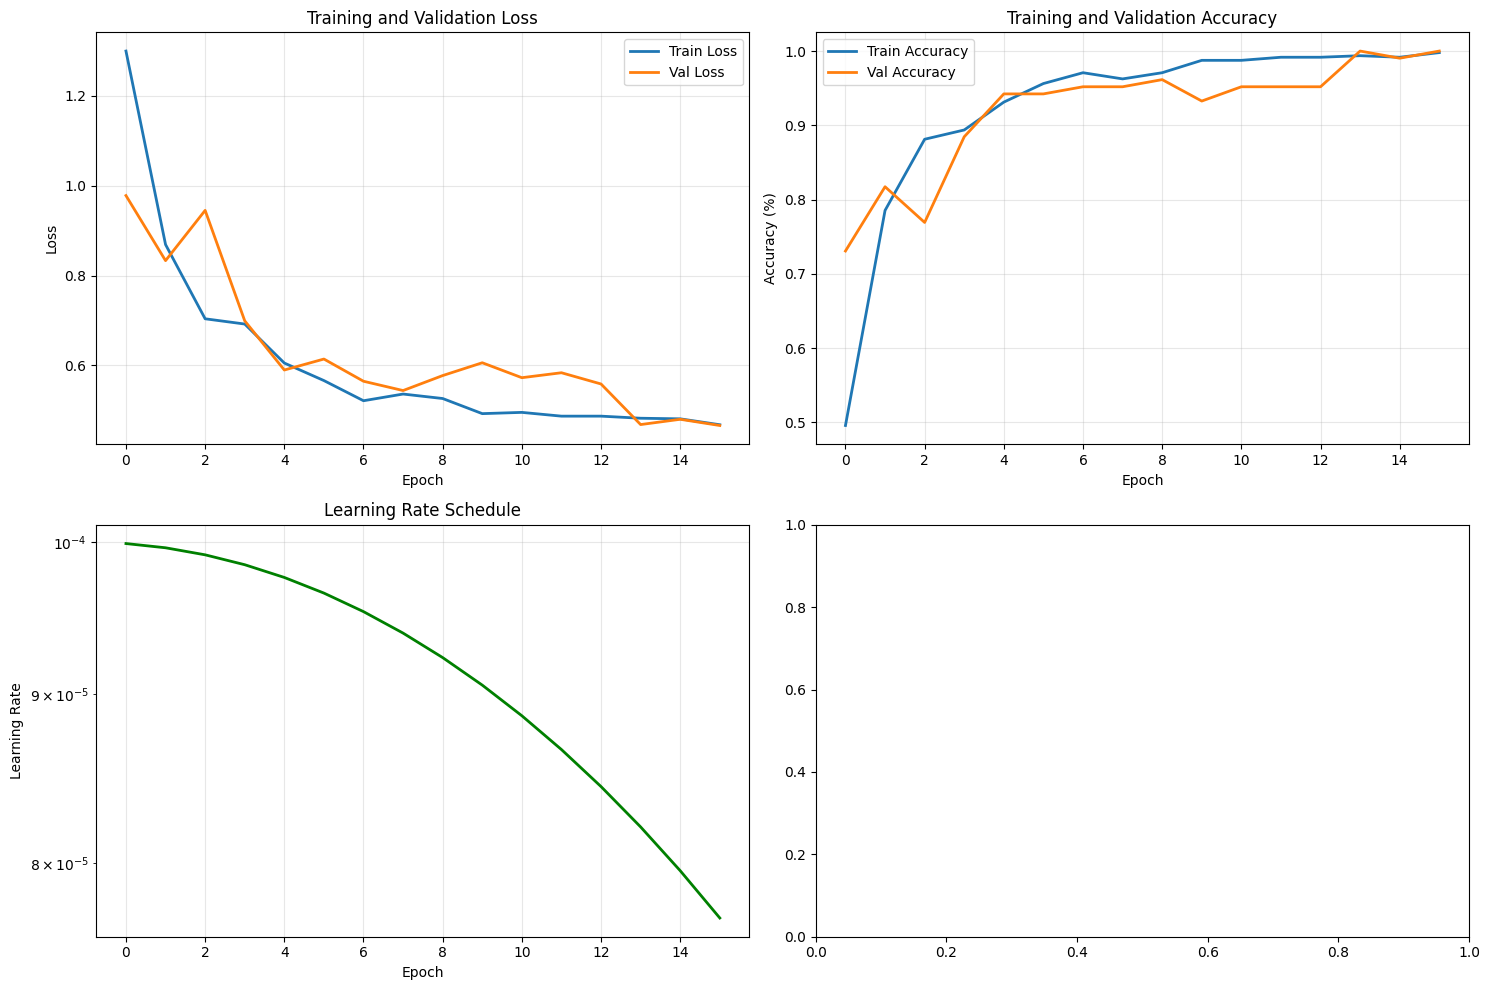


✅ Training visualization saved!


In [12]:
# Save history (resolve paths)
history_path = resolve_path(config['logging']['log_dir']) / "training_history.json"
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"💾 Training history saved to {history_path}")

# Plot training history
viz_dir = resolve_path(config['output']['visualizations_dir'])
viz_dir.mkdir(parents=True, exist_ok=True)
plot_training_history(
    history,
    save_path=str(viz_dir / "training_history.png")
)

print("\n✅ Training visualization saved!")

## 7. Summary

### Training Completed! 🎉

**Next Steps:**
1. Proceed to `03_evaluation_and_visualization.ipynb` for detailed evaluation
2. Use `04_inference_and_prediction.ipynb` for making predictions

---